# Brick optimisation layer automation

Created 20/08/2024

Objectives:
* Automate layer optimisation from "larger_unitaries" notebook to check optimisation performance on deeper layers of unitaries.
* Multiply resulting MPOs, check cohomology

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce
from operator import mul

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment
)

from SPTOptimization.Optimizers.utils import (
    one_site_optimization_sweep_right
)

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [8]:
f_name = DATA_DIR + r"/0_90.h5"

In [9]:
f_name

'../data/transverse_cluster_200_site_dmrg/0_90.h5'

In [10]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [11]:
MAX_VIRTUAL_BOND_DIM = 8

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [14]:
test = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    [np_X, np_I]*50
)

In [15]:
test.compute_svd_symmetry_action()

In [16]:
test.right_projected_symmetry_state

<npc.Array shape=(8, 8) labels=['vR', 'vR*']>

In [17]:
test.left_projected_symmetry_state

<npc.Array shape=(8, 8) labels=['vL', 'vL*']>

In [18]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [19]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

### Leg and label functions

In [20]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [21]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [22]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [23]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [24]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [25]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [26]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [27]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

### Other

In [28]:
def contract_virtual_legs(tl, tr):
    return npc.tensordot(tl, tr, ['vR', 'vL'])

In [29]:
def combine_tensors(tensors):
    out = reduce(contract_virtual_legs, tensors)

    leg_labels = [
        extract_single_physical_leg_label_from_tensor(t)
        for t in tensors
    ]

    out = out.combine_legs(leg_labels)

    return out

In [30]:
def combine_b_tensors(b_tensors):
    renamed_tensors = [
        b.replace_label('p', f'p{i}')
        for i, b in enumerate(b_tensors)
    ]

    return combine_tensors(renamed_tensors)

In [31]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [32]:
def svd_reduce_split_tensor(t, max_inner_dim=MAX_VIRTUAL_BOND_DIM, form='B'):
    # To-do: Add form conditions
    U, S, VH = npc.svd(t, compute_uv=True, inner_labels=['vR', 'vL'])

    # Update this code for other forms. Check tenpy docks.
    # Create U, V exponents and plug into for loop.
    for i in range(U.shape[1]):
        U[:, i] *= S[i]

    if max_inner_dim is not None:
        U = U[:, :max_inner_dim]
        VH = VH[:max_inner_dim, :]

    return U, VH

In [109]:
def split_combined_b(b, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = b.split_legs()

    num_sites = t.ndim - 2
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    out_bs = list()

    for i, ll in enumerate(p_leg_labels[:-1]):
        tail_legs = p_leg_labels[(i+1):]
        t = t.combine_legs([['vL', ll], ['vR', *tail_legs]])

        U, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            form='B'
        )

        bl = U.split_legs().replace_label(ll, 'p')
        bl.itranspose(['vL', 'p', 'vR'])
        out_bs.append(bl)

        t = VH.split_legs()

    bl = t.replace_label(p_leg_labels[-1], 'p')
    bl.itranspose(['vL', 'p', 'vR'])
    out_bs.append(bl)

    return out_bs

In [34]:
def split_b(b, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    leg_label = get_physical_leg_labels(b)[0]

    if is_single_physical_leg_label(leg_label):
        return [b,]
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_b(b, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [108]:
def split_combined_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = u.split_legs()
    num_sites = t.ndim //2
    
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    p_leg_labels_hc = [l+'*' for l in p_leg_labels]
    out_ws = list()

    for i, (ll, ll_hc) in enumerate(zip(p_leg_labels[:-1], p_leg_labels_hc[:-1])):
        tail_legs = p_leg_labels[(i+1):]
        tail_legs_hc = p_leg_labels_hc[(i+1):]

        left_leg_labels = [ll, ll_hc]
        if 'vL' in t.get_leg_labels():
            left_leg_labels.append('vL')
    
        t = t.combine_legs([left_leg_labels, [*tail_legs, *tail_legs_hc]])

        U, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            form='B'
        )

        wl = U.split_legs().replace_labels([ll, ll_hc], ['p', 'p*'])
        #wl.itranspose(['p', 'p*'])
        out_ws.append(wl)

        t = VH.split_legs()

    wl = t.replace_labels(
        [p_leg_labels[-1], p_leg_labels_hc[-1]],
        ['p', 'p*']
    )
    #wl.itranspose(['p', 'p*'])
    out_ws.append(wl)

    out_ws[0] = (
        out_ws[0]
        .add_leg(left_trivial_leg_charge, 0, label='vL')
    )
    
    out_ws[-1] = (
        out_ws[-1]
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out_ws

In [36]:
def split_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
            p_leg_labels=None):
    leg_label = get_physical_leg_labels(u)[0]

    if is_single_physical_leg_label(leg_label):
        return [unitary_to_mpo_tensor(u),]
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_u(u, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError
    

In [37]:
def unitary_to_mpo_tensor(u):
    out = (
        u
        .add_leg(left_trivial_leg_charge, 0, label='vL')
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out

In [38]:
def multiply_individual_mpo_tensors(w1, w2):
    w1 = w1.replace_labels(['vR', 'vL'], ['vR1', 'vL1'])
    w2 = w2.replace_labels(['vR', 'vL'], ['vR2', 'vL2'])

    w = (
        npc.tensordot(w1, w2, [['p'], ['p*']])
        .combine_legs([['vR1', 'vR2'], ['vL1', 'vL2']])
        .replace_labels(['(vR1.vR2)', '(vL1.vL2)'], ['vR', 'vL'])
    )

    return w

In [39]:
def group_elements(l, group_size, offset=0):
    first, rest = l[:offset], l[offset:]

    num_rest_groups = ((len(rest)-1)//group_size) + 1

    groups = [first,] if first else list()

    for i in range(num_rest_groups):
        first_index = i*group_size
        last_index = (i+1)*group_size
        groups.append(rest[first_index:last_index])

    return groups

In [40]:
def combine_grouped_b_tensors(grouped_bs):
    out = list()

    for group in grouped_bs:
        if len(group) == 1:
            out.append(group[0])
        else:
            out.append(combine_b_tensors(group))

    return out

In [122]:
def reduce_virtual_mpo_dim(wl, wr, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    # wl = wl.replace_labels(['p', 'p*'], ['pl', 'pl*'])

    wl = wl.combine_legs(['p', 'vL', 'p*'])
    wr = wr.combine_legs(['p', 'vR', 'p*'])
    w = npc.tensordot(wl, wr, ['vR', 'vL'])

    wl, wr = svd_reduce_split_tensor(
        w,
        max_inner_dim=max_virtual_bond_dim,
        form='B'
    )

    wl = wl.split_legs()
    wr = wr.split_legs()

    return wl, wr

In [123]:
def multiply_mpos(top_ws, bottom_ws, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    ws = list()
    
    for w1, w2 in zip(top_ws, bottom_ws):
        w = multiply_individual_mpo_tensors(w1, w2)
        ws.append(w)


    for i in range(len(ws)-1):
        ws[i], ws[i+1] = reduce_virtual_mpo_dim(
            ws[i],
            ws[i+1],
            max_virtual_bond_dim=max_virtual_bond_dim
        )

    return ws

### Layer function

In [139]:
def optimise_layer(
        left_environment,
        top_b_tensors,
        block_width,
        block_offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors=None,
        num_iterations=1,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    ):

    if bottom_b_tensors is None:
        bottom_b_tensors = top_b_tensors

    top_grouped_bs = group_elements(
        top_b_tensors,
        block_width,
        block_offset
    )
    bottom_grouped_bs = group_elements(
        bottom_b_tensors,
        block_width,
        block_offset
    )

    top_combined_bs = combine_grouped_b_tensors(top_grouped_bs)
    bottom_combined_bs = combine_grouped_b_tensors(bottom_grouped_bs)

    unitaries = [
        get_identity_operator(t) for t in top_combined_bs
    ]
    
    expectations.append(list())

    for _ in range(num_iterations):
        exps, *_ = one_site_optimization_sweep_right(
            left_environment,
            top_combined_bs,
            unitaries,
            bottom_combined_bs
        )

        expectations[-1].append(exps)

    for i, u in enumerate(unitaries):
        b = top_combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        top_combined_bs[i] = new_b

    new_top_bs = list()

    for b in top_combined_bs:
        new_top_bs.extend(split_b(b, max_virtual_bond_dim=max_virtual_bond_dim))

    for i, b in enumerate(new_top_bs):
        top_b_tensors[i] = b

    current_unitary_w_tensors = list()

    for u in unitaries:
        current_unitary_w_tensors.extend(split_u(u, max_virtual_bond_dim=max_virtual_bond_dim))

    if previous_mpo_w_tensors == []:
        for w in current_unitary_w_tensors:
            previous_mpo_w_tensors.append(w)
    else:
        new_mpo_w_tensors = multiply_mpos(
            previous_mpo_w_tensors,
            current_unitary_w_tensors,
            max_virtual_bond_dim=max_virtual_bond_dim
        )

        for i, w in enumerate(new_mpo_w_tensors):
            previous_mpo_w_tensors[i] = w

# Optimisation

## Layer by layer test

In [44]:
test.right_symmetry_index

149

In [62]:
bs = [
    test_psi.get_B(i)
    for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
]

In [63]:
len(bs)

25

In [65]:
left_environment = test.right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = bs.copy()
block_width = 3
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [66]:
len(bottom_b_tensors), len(top_b_tensors), len(previous_mpo_w_tensors)

(25, 25, 0)

In [67]:
optimise_layer(
    left_environment,
    top_b_tensors,
    block_width,
    0,
    expectations,
    previous_mpo_w_tensors,
    bottom_b_tensors,
    num_iterations
)

In [68]:
expectations

[[[1.1772577977037573,
   1.1786923957132351,
   1.1786923957132347,
   1.1786923957132354,
   1.1786923957132354,
   1.1786923957132358,
   1.178692395713236,
   1.1786923957132371,
   1.1786923957132367],
  [1.1786924590661374,
   1.178692459276027,
   1.1786924592760268,
   1.1786924592760282,
   1.1786924592760273,
   1.178692459276027,
   1.1786924592760264,
   1.178692459276027,
   1.1786924592760268],
  [1.1786924592777763,
   1.1786924592777923,
   1.1786924592777919,
   1.1786924592777919,
   1.1786924592777916,
   1.1786924592777923,
   1.1786924592777914,
   1.1786924592777923,
   1.178692459277792]]]

In [70]:
optimise_layer(
    left_environment,
    top_b_tensors,
    block_width,
    1,
    expectations,
    previous_mpo_w_tensors,
    bottom_b_tensors,
    num_iterations
)

In [71]:
expectations

[[[1.1772577977037573,
   1.1786923957132351,
   1.1786923957132347,
   1.1786923957132354,
   1.1786923957132354,
   1.1786923957132358,
   1.178692395713236,
   1.1786923957132371,
   1.1786923957132367],
  [1.1786924590661374,
   1.178692459276027,
   1.1786924592760268,
   1.1786924592760282,
   1.1786924592760273,
   1.178692459276027,
   1.1786924592760264,
   1.178692459276027,
   1.1786924592760268],
  [1.1786924592777763,
   1.1786924592777923,
   1.1786924592777919,
   1.1786924592777919,
   1.1786924592777916,
   1.1786924592777923,
   1.1786924592777914,
   1.1786924592777923,
   1.178692459277792]],
 [[1.1759283311506579,
   1.3036371285268888,
   1.304319413990794,
   1.3043274815077306,
   1.3043293129967917,
   1.3043293133943508,
   1.3043293612794784,
   1.3043293612956264,
   1.3043293625071024],
  [1.3043293625071033,
   1.3043297813348427,
   1.3043297920068855,
   1.3043297924226895,
   1.3043297925576955,
   1.3043297926116986,
   1.3043297926384672,
   1.3043297

In [72]:
optimise_layer(
    left_environment,
    top_b_tensors,
    block_width,
    2,
    expectations,
    previous_mpo_w_tensors,
    bottom_b_tensors,
    num_iterations
)

In [73]:
expectations

[[[1.1772577977037573,
   1.1786923957132351,
   1.1786923957132347,
   1.1786923957132354,
   1.1786923957132354,
   1.1786923957132358,
   1.178692395713236,
   1.1786923957132371,
   1.1786923957132367],
  [1.1786924590661374,
   1.178692459276027,
   1.1786924592760268,
   1.1786924592760282,
   1.1786924592760273,
   1.178692459276027,
   1.1786924592760264,
   1.178692459276027,
   1.1786924592760268],
  [1.1786924592777763,
   1.1786924592777923,
   1.1786924592777919,
   1.1786924592777919,
   1.1786924592777916,
   1.1786924592777923,
   1.1786924592777914,
   1.1786924592777923,
   1.178692459277792]],
 [[1.1759283311506579,
   1.3036371285268888,
   1.304319413990794,
   1.3043274815077306,
   1.3043293129967917,
   1.3043293133943508,
   1.3043293612794784,
   1.3043293612956264,
   1.3043293625071024],
  [1.3043293625071033,
   1.3043297813348427,
   1.3043297920068855,
   1.3043297924226895,
   1.3043297925576955,
   1.3043297926116986,
   1.3043297926384672,
   1.3043297

In [74]:
optimise_layer(
    left_environment,
    top_b_tensors,
    block_width,
    0,
    expectations,
    previous_mpo_w_tensors,
    bottom_b_tensors,
    num_iterations
)

In [75]:
expectations

[[[1.1772577977037573,
   1.1786923957132351,
   1.1786923957132347,
   1.1786923957132354,
   1.1786923957132354,
   1.1786923957132358,
   1.178692395713236,
   1.1786923957132371,
   1.1786923957132367],
  [1.1786924590661374,
   1.178692459276027,
   1.1786924592760268,
   1.1786924592760282,
   1.1786924592760273,
   1.178692459276027,
   1.1786924592760264,
   1.178692459276027,
   1.1786924592760268],
  [1.1786924592777763,
   1.1786924592777923,
   1.1786924592777919,
   1.1786924592777919,
   1.1786924592777916,
   1.1786924592777923,
   1.1786924592777914,
   1.1786924592777923,
   1.178692459277792]],
 [[1.1759283311506579,
   1.3036371285268888,
   1.304319413990794,
   1.3043274815077306,
   1.3043293129967917,
   1.3043293133943508,
   1.3043293612794784,
   1.3043293612956264,
   1.3043293625071024],
  [1.3043293625071033,
   1.3043297813348427,
   1.3043297920068855,
   1.3043297924226895,
   1.3043297925576955,
   1.3043297926116986,
   1.3043297926384672,
   1.3043297

## Multiple layers test

In [76]:
left_environment = test.right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = bs.copy()
block_width = 3
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [77]:
for i in range(30):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = i % block_width

    optimise_layer(
        left_environment,
        top_b_tensors,
        block_width,
        offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors,
        num_iterations
    )

Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25


In [79]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

In [80]:
final_expectations

[1.178692459277792,
 1.304329792757731,
 1.3055565592423497,
 1.3210430184221642,
 1.3294220981605853,
 1.3216450588496838,
 1.3231019583003234,
 1.3196158180573851,
 1.3172956799251647,
 1.3161539257816188,
 1.3152031443244594,
 1.3127285610229544,
 1.3119925058470687,
 1.3009959165865896,
 1.299853379097181,
 1.2985950819897698,
 1.2915737527565667,
 1.2919315001078355,
 1.290181852505407,
 1.288031532577377,
 1.286843645927195,
 1.2859711291298754,
 1.2830823632780883,
 1.2798108832859254,
 1.2787051094829949,
 1.272206513095139,
 1.2629724197525027,
 1.2622515047612897,
 1.258586015488152,
 1.250729200924993]

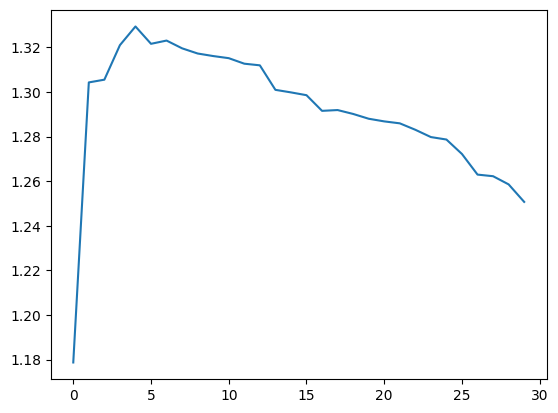

In [81]:
plt.plot(final_expectations)

In [83]:
t = left_environment

for b in bs:
    t = npc.tensordot(t, b, [['vR',], ['vL',]])
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

npc.trace(t)

(-0.08812673606713177+0j)

In [84]:
npc.trace(left_environment)

(-0.08812673606713205+0j)

In [85]:
npc.trace(test.left_projected_symmetry_state)

(-0.000944779398154762+0j)

In [86]:
t = left_environment

for b in top_b_tensors:
    t = npc.tensordot(t, b, [['vR',], ['vL',]])
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

npc.trace(t)

(-0.083159237657227+0j)

In [140]:
left_environment = test.right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = bs.copy()
block_width = 3
expectations_12 = list()
previous_mpo_w_tensors = []
num_iterations = 3
max_virtual_bond_dim=12

In [141]:
for i in range(30):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = i % block_width

    optimise_layer(
        left_environment,
        top_b_tensors,
        block_width,
        offset,
        expectations_12,
        previous_mpo_w_tensors,
        bottom_b_tensors,
        num_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25


In [142]:
final_expectations_12 = list()

for l in expectations_12:
    final_expectations_12.append(l[-1][-1])

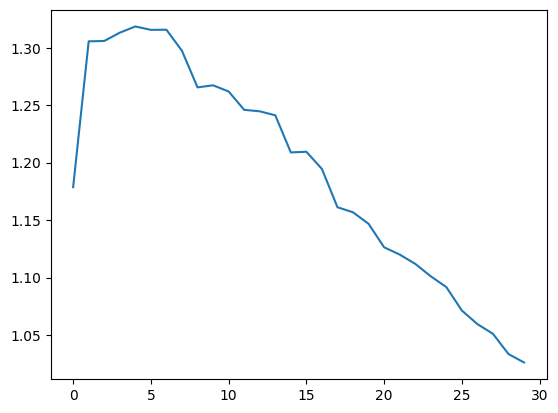

In [143]:
plt.plot(final_expectations_12)

This is worse! That makes no sense.

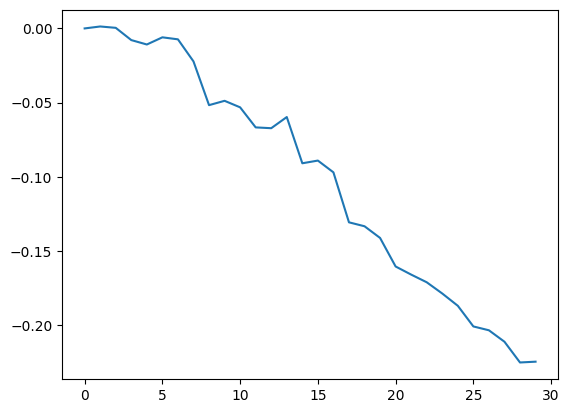

In [144]:
y = np.array(final_expectations_12) - np.array(final_expectations)

plt.plot(y)

In [145]:
top_b_tensors

[<npc.Array shape=(8, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(12, 2, 12) la

In [146]:
previous_mpo_w_tensors

[<npc.Array shape=(2, 1, 2, 4) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 4, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array shape=(2, 12, 2, 12) labels=['p', 'vL', 'p*', 'vR']>,
 <npc.Array s

To-do:
* Check normalisation of updated MPS, how to address?